# A Tutorial of Variational Latent Gaussian Process Model

This tutorial shows how to use the code to reproduce part of the result in the paper.

Firstly import modules.

In [1]:
import os
from os import path as op

import numpy as np
from scipy import stats
from scipy import linalg

import vlgp
from vlgp import util, simulation

Then import and set up graphics. Borrow the palette from seaborn. 

In [2]:
import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Create the paths to the data and ouput directories. These two subdirectories are expected to exist in current directory.

In [3]:
datapath = op.abspath('../data')
outputpath = op.abspath('../output')

## Lorenz Dynamics

We simulate a dataset driven by 3-dimensional Lorenz dynamics defined by the following differential equations,
\begin{align} 
    x_1' &= \sigma(x_2 - x_1)     \\
    x_2' &= x_1(\rho - x_3) - x_2 \\
    x_3' &= x_1 x_2 - \beta x_3.
\end{align}

Each sample consists of 10 trials of 50 spike trains. Each trial contains 1000 time bins. The discrete latent dynamics are sampled with the time step of 0.0015. The parameters are set to $\sigma=10$, $\rho=28$ and $\beta=2.667$. We normalize the dynamics and discard the first 2000 points to get stable result.

In [4]:
ntrial = 10  # number of trials
nbin = 1000  # number of time bins of each trial
nneuron = 50 # number of neurons (spike trains)
dim = 3 # latent dimension

To reproduce the same results as that in the paper, set the random seed and simulate 5 samples.

In [5]:
np.random.seed(0)
skip = 2000
lorenz = simulation.lorenz(skip +  ntrial * nbin, dt=1.5e-3, s=10, r=28, b=2.667, x0=np.random.random(3) * 2)
lorenz = (lorenz - lorenz.mean(axis=0)) / linalg.norm(lorenz, axis=0, ord=np.inf)
x = lorenz[skip:, :].reshape((ntrial, nbin, dim))  # latent dynamics in proper shape

Plot the first trial.

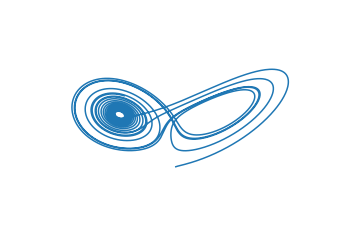

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(*lorenz.T)
plt.axis("off")
plt.show()
plt.close()

Then simulate spike trains with 10-step history filter given the simulated latent dynamics. The elements of loading matrix is randomly generated from $(1, 2)$ with random signs. The base firing rate is 15Hz. 

The simulation function `simulation.spike` gives spike trains, design matrix of regression part and the true firing rates. We sort the loading matrix by row.

In [7]:
np.random.seed(0)
bias = np.log(15 / nbin)  # log base firing rate
a = (np.random.rand(dim, nneuron) + 1) * np.sign(np.random.randn(dim, nneuron)) # loading matrix
b = np.vstack((bias * np.ones(nneuron), -10 * np.ones(nneuron), -10 * np.ones(nneuron), -3 * np.ones(nneuron), 
                  -3 * np.ones(nneuron), -3 * np.ones(nneuron), -3 * np.ones(nneuron), -2 * np.ones(nneuron),
                  -2 * np.ones(nneuron), -1 * np.ones(nneuron), -1 * np.ones(nneuron)))  # regression weights

y, _, rate = simulation.spike(x, a, b)
sample = dict(y=y, rate=rate, x=x, alpha=a, beta=b)
util.save(sample, op.join(datapath, 'lorenz.npy'))  # store the simulation

Load the first sample and plot the spike trains.

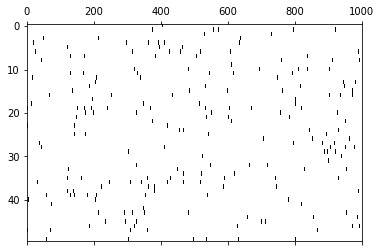

In [8]:
# Raster plot
plt.figure()
plt.spy(sample['y'][0, ...].T, aspect='auto')
plt.show()
plt.close()

### Model Fitting

Now let us do inference on the first sample. Firstly we need to set the random seed in order to get reproducible result because the algorithm does subsampling in the hyperparameters optimization steps. 

The `fit` function requires the observation array, list of channel types, initial values of hyperparameters, lag and rank of prior covariance decomposition. The observation array is supposed to be in the shape of (trial, bin, channel). The 'spike' channel indicates it is a spike train (Poisson). 

The function also needs the true values of latent and parameters to calculate the angle between subspaces and other statistics.

The rest arguments are options controlling the behavior of algorithm.
* niter: max number of iterations
* tol: relative tolerance for checking convergence
* verbose: display info in every iteration
* learn_post: optimize the posterior
* learn_param: optimize the parameters
* learn_hyper: optimize hyperparamters
* nhyper: optimize hyperparameters every nhyper iteration

We can save the fitted model in HDF5 format. Note that HDF5 does not support array of strings and thus remove it before saving.

In [9]:
np.random.seed(0)

trials = [{'ID': i, 'y': y} for i, y in enumerate(sample['y'])]  # make trials

fit = vlgp.fit(
    trials,  
    n_factors=3,  # latent dimensionality
    EMniter=20  # number of iterations
)


vLGP
Initializing...
Fitting...
EM iteration 1
EM iteration 2
EM iteration 3
EM iteration 4
EM iteration 5
EM iteration 6
EM iteration 7
EM iteration 8
EM iteration 9
EM iteration 10
EM iteration 11
EM iteration 12
EM iteration 13
EM iteration 14
EM iteration 15
EM iteration 16
EM iteration 17
EM iteration 18
EM iteration 19
EM iteration 20
Inferring...
Done


In [10]:
trials = fit['trials']  # extract trials
mu = np.stack(trial['mu'] for trial in trials) # extract posterior latent
mu = np.reshape(mu, (-1, dim))
W = np.linalg.lstsq(mu, x.reshape((-1, dim)))[0]
mu = mu @ W

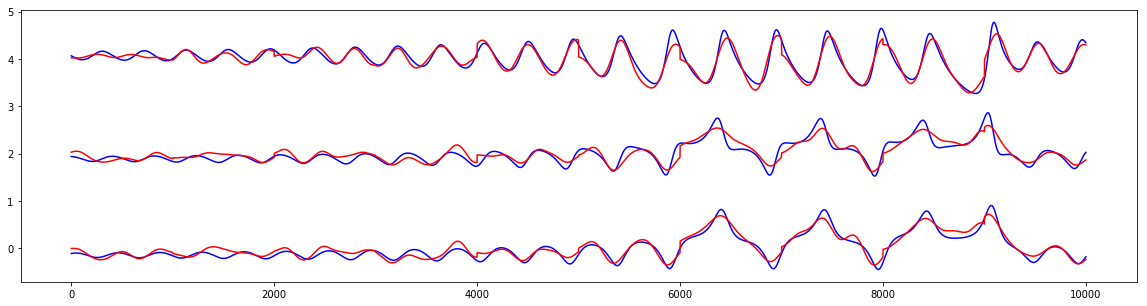

In [11]:
# Plot posterior latent
plt.figure(figsize=(20, 5))
plt.plot(x.reshape((-1, dim)) + 2 * np.arange(3), color="b")
plt.plot(mu + 2 * np.arange(3), color="r")
plt.axis("off")
plt.show()
plt.close()